----------------------------------------------------------------------------------------------------------
***********************************************************************************************************

# <span style="color:Purple"> Computer vision for machine learning Project: "Detecting hand gestures"


#### Task 3 & 4: 

#### Author: Lynda Attouche
#### Link: https://colab.research.google.com/drive/1nb6DTYYut70uQ47FPm41KzbI-S9OIwzZ?usp=sharing
*******************************************************************************************
----------------------------------------------------------------------------------------------------------


## README
* Throughout this notebook, no special commands are needed to run the code. Simply run the cells in order. 

* The code of some tasks loops endlessly, to stop them a counter has been set up. It is possible to comment the counter and so to move on to the next task, just stop it manually and run from the next cell 

## Imports

#### Libraries

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
from PIL import Image
import io
import cv2
from matplotlib import pyplot as plt
import time

#### OpenCV

In [2]:
!git clone https://github.com/opencv/opencv/

Cloning into 'opencv'...
remote: Enumerating objects: 304494, done.
remote: Total 304494 (delta 0), reused 0 (delta 0), pack-reused 304494
Receiving objects: 100% (304494/304494), 493.72 MiB | 22.14 MiB/s, done.
Resolving deltas: 100% (211892/211892), done.
Checking out files: 100% (7038/7038), done.


### Helper functions



In [3]:
#Converting image types
def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [4]:
face_cascade_path = "/content/opencv/data/haarcascades/haarcascade_frontalface_alt.xml"
face_cascades = cv2.CascadeClassifier(face_cascade_path)

In [5]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div'); //create new div element
      document.body.appendChild(div); //add the content of the new element to the DOM

      video = document.createElement('video'); //create new video element
      video.setAttribute('playsinline', ''); //setting attributes of the element

      div.appendChild(video); //add the content of video the the div element

      //Selecting facing mode of the video stream
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play(); //playing video

      canvas =  document.createElement('canvas'); //create new canvas element
      // set canvas size 
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div'); //create a new div element, will contains the output
      document.body.appendChild(div_out); //add the content of the div_out to the DOM
      img = document.createElement('img'); //create the image element (will contain the image/capture we'll take)
      div_out.appendChild(img); //add the image element to the output div
    }

    //taking the capture and storing it
    async function capture(){
        return await new Promise(function(resolve, reject){ // Wait for Capture to be clicked.
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0); //draw an image onto the canvas.
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    //displaying the capture 
    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

In the following cell, a function has been defined in order to calculate the region on which the face search will be carried out at time **t+1** taking into account the previous face delimitation at time **t** (if we refer to the figure on moodle)

In [6]:
def compute_region(img,margin,prev):
  """
  Computes  region of interest 
  @params:
          - img (array): image on which detection will be done
          - margin (int): the margin to be taken from the previous region (the coordinate shift)
          - prev (array): previous face detection
  @return 
          - region of interest 
  """
  # as seen in the previous task, the cascadeClassifier returns a face as a rectangle
  # so this is the case for the param prev, ie: prev = (x,y,w,h) = (prev[0],prev[1],prev[2],prev[3])
  # where (x,y) is the top left corner and (w,h) the bottom right corner
  # the goal is then to compute (x',y',w',h') considering the margin and previous region to define the new region such that:
  # x' = x - margin
  # y' = y - margin 
  # w' = (x+w) + margin
  # h' = (y+h) + margin

  #top left corner
  x_prime = prev[0] - margin 
  y_prime = prev[1] - margin 

  #bottom right
  w_prime = prev[0]+prev[2]+margin 
  h_prime = prev[1]+prev[3]+margin 

  # Note: 
  #the new region must stay in the image and not be out of it (I noticed that after some tests because the results were weird)
  # i.e:
  #top left corner should not be negative (as a subtraction is made from the previous x and y) càd:  x_prime>=0 and y_prime>=0
  #if either x or y (or both of them) is negative, it should be set to 0
  x_prime= max(0,x_prime) # = 0 if x_prime<0
  y_prime = max(0,y_prime) #= 0 if y_prime<0

  #for the bottom right corner should not be out of the image in the sense that we should not obtain values that go beyond the coordinate of the 
  #image (since w' for example is a result of increasing x+w with a margin )
  #to handle that possible problem, the value should be set to the image height or width (depends on which coordinate) of the image, as follows
  (imgH,imgW) = img.shape[0], img.shape[1]
  w_prime = min(imgW,w_prime) # = image width if x_prime>image width
  h_prime = min(imgH,h_prime) # = image heigh if y_prime>image heigh

  return (x_prime,y_prime,w_prime-x_prime,h_prime-y_prime)

In [7]:
def detect_face(im,prev,margin):
  """
  Detects face regions
  @param:
        - im (array): image/capture
        - prev (array): previous detected area
        - margin (int): margin for detection 
  @return 
        detected region w/out margin 
  """
  new_reg = im.copy() #starter region, whole image (first step, step t before detection)
  curr_face = None #contains the detected face
  #if we didn't detect a face yet
  if prev is not None :
    #print("I am here")
    x_prime,y_prime,w_prime,h_prime = compute_region(im,margin,prev) #computing the new region (of timestep t+1)
    #my new region:
    new_reg = im[y_prime:y_prime+h_prime,x_prime:x_prime+w_prime] 
    #plot the rectangle 
    cv2.rectangle(im, (x_prime,y_prime), (x_prime+w_prime, y_prime+h_prime), (255,0,0),2)

  gray = cv2.cvtColor(new_reg, cv2.COLOR_BGR2GRAY) # Converting image to gray scale
  #face detection using face cascade 
  faces = face_cascades.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=4)
  if len(faces)==0: # no face has been detected 
    prev = None  #we won't have a roi *
  else:
    curr_face = faces[0] #we pick the first face detected
    if prev is None: #previous region surrounding the face picked
      (x,y,w,h) = curr_face #get the face region coordinates
    else: #we already have a face, so we have already computed xprime,yprime,
      (x,y,w,h)=(x_prime+curr_face[0], y_prime+curr_face[1], curr_face[2], curr_face[3]) #updating with the new coordinates (primes)
    #so we update our region 
    prev = (x,y,w,h)
    #we plot the rectangle 
    cv2.rectangle(im, (x,y), (x+w, y+h), (255,0,0),2)    
  return curr_face

## TASK 3
The goal of this task is to build a histogram corresponding to the face and then track it. So the first step is to detect the face frame, compute the histogram and track the face using cam shift. This is done in the following cells:

#### 1. Face detection
In this part of the task, the face frame is detected using the algorithm implemented in task 2 ( corrected version) in order to calculate the histogram.

In [8]:
start_time = time.time()
VideoCapture()
eval_js('create()')

#out first starting box: 
prev = None 
margin = 50 #randomly chosen
b = True
c = 0 #counter just to stop the algorithm, since it takes time (infinit loop)
while b:
  byte = eval_js('capture()')
  im = byte2image(byte) 
  curr_face = detect_face(im,prev,margin)
   
  if c>20:
    #in this part, I decided to display only the face frame so I can play with the distance to the camera and I didn't display the big rectangle
    #around, if you want to display it, you just have to return "prev" from the fuction that computes the face detection and display it using:
    #eval_js('showimg("{}")'.format(image2byte(im[prev[1]:prev[1]+prev[3], prev[0]:prev[0]+prev[2]])))
    face_frame = im[curr_face[1]:curr_face[1]+curr_face[3], curr_face[0]:curr_face[0]+curr_face[2]]
    tracking_window_face = curr_face
    eval_js('showimg("{}")'.format(image2byte(face_frame)))
    break
  c +=1
  eval_js('showimg("{}")'.format(image2byte(im)))

<IPython.core.display.Javascript object>

#### 2. Computing histogram for detected face

Now that the face frame has been detected, the histogram of the face colour is computed. This is done using the HUE channel. It allows us afterwards to make a back projection. The aim is to, taking into account this histogram, detect the parts of the image that have similar colours to the face. In other words, for each pixel of the image, the probability that its colour belongs to the histogram is computed. Thus, we can capture the elements of the image that have the same colour as the face. If we forget the fact of wearing clothes or having objects of the same colour as the face, the parts of the image that will have a very high probability will be the visible parts of the body (i.e. the hands, neck, shoulders, arms...

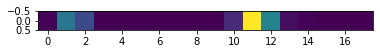

In [9]:
def hsv(face_frame):
  """
  Transforms the face frame into HSV and computes histogram
  @params:
        - face_frame: the frame representing the face
  @return:
        - mask: hsv with mask to deal with brightness and darkness pixels
        - histo: histogram computed from the hsv
  """
  #transforming the detected face frame into HSV
  hsv = cv2.cvtColor(face_frame, cv2.COLOR_BGR2HSV)
  #Creating a mask using inRange for the pixels to deal with brightness and darkness
  #allows us to take into consideration the pixels that are too dark and/or too bright
  #the parameters of the mask were found just by playing and testing many of values (the tests were held in one only place)
  mask = cv2.inRange(hsv,np.array((0,60,32)), np.array((180,200,200)))
  #computing histogram of face frame using hue channel ie [0]
  #here we used: 18 as bins for the histogram
  #and the range of the hue was set to [0,180]
  histo = cv2.calcHist([hsv],[0], mask, [18], [0,180])
  #normalizing histogram 0-255
  histo = cv2.normalize(histo, histo, 0, 255, cv2.NORM_MINMAX)
  return mask, hsv,histo

mask,hsv,histo = hsv(face_frame)
#Displaying histogram
plt.imshow(histo.reshape(1,-1))
plt.show()

(array([13.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ], dtype=float32),
 <a list of 10 Patch objects>)

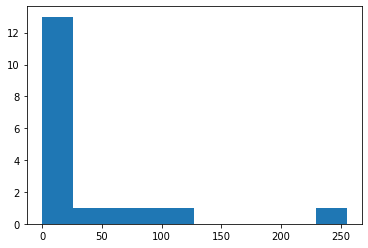

In [10]:
#more meaningful/ clearer display
plt.hist(histo)

#### 3. CAMshift application

Now, the aim is to track the face on the image (the capture taken via the camera) using the back projection of the histogram calculated previously. To do this, we use CAMShift (Continuously Adaptive Meanshift). It is an algorithm that allows us to track the face by adapting to different constraints we may have. Constraints such as having a tilted face, a face far or close to the camera, etc.

In [14]:
######### Cam shift########
VideoCapture()
eval_js('create()')
#this following line describes a criteria to stop camshift algorithm
#so this algorithm stops when 10 iterations have been carried out or when the computed value is not changing in all the direction by a factor of 1pt 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
c = 0 #this counter is used to stop the algorithm (because it takes time since my laptop camera is not good)
tracking_window_hand =  (0,0,im.shape[1],im.shape[0]) #defiens hand window used for tracking the hand
while True:
  byte = eval_js('capture()') # capture
  im = byte2image(byte) #converting capture 
  # Converting the image to HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Computing mask (inRange) as done in the previous cell
  mask = cv2.inRange(hsv,np.array((0,60,32)), np.array((180,200,200)))
  # Back projecting the frame histogram into the hsv image
  # We use only channel Hue (ie channel 0)
  # and the range of the hue was set to [0,180]
  #basically, we have the histogram of colors of the face and we will backproject it in our current image 
  #to detect the part of the image that fit the histogram (have same color as the face)
  prob = cv2.calcBackProject([hsv],[0], histo, [0,180],scale= 1)
  
  # Apply the mask to the backprojection output
  # Helps us to deal with dark or/and bright pixels
  prob = prob & mask

  # Applying Cam shift
  # it takes as arguments:
  # the computed back projection with mask
  # the windows where the face is stored 
  # term_crit, the criteria that stops the algorithm 
  _, tracking_window_face = cv2.CamShift(prob, tracking_window_face, term_crit)
  # plot a bounding box with coordiantes `tracking_window_face` in the image
  (x,y,w,h) = tracking_window_face
  cv2.rectangle(im, (x,y), (x+w, y+h), (255,0,0), 2)  

  if c>10:  #this helps to conditionnally stop the algo
    break
  c +=1 
  #eval_js('showimg("{}")'.format(image2byte(im))) #displaying image
  #eval_js('showimg("{}")'.format(image2byte(mask))) #displaying mask
  eval_js('showimg("{}")'.format(image2byte(prob))) #displaying back projection output

<IPython.core.display.Javascript object>

## TASK 4

The purpose of this task is to detect the hand. To do this we have to erase the face. To better understand, as we have the color histogram corresponding to the color of the face (computed in task 3), we can track it on the image but we have also seen that we can track the other parts of the body, in particular the hands. And here, we want to keep only the latter. So we start by detecting the face and tracking it with CAMShift and then erase it by setting its probability to 0 (the probability on the face region). Then, we use CAMshift to detect the hands that will have the highest probability (using a backprojection of the face histogram) in the image without the face.

In [16]:
VideoCapture()
eval_js('create()')
#this following line describes a criteria to stop camshift algorithm
#so this algorithm stops when 10 iterations have been carried out or when the computed value is not changing in all the direction by a factor of 1pt 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
tracking_window_hand = (0,0,im.shape[1],im.shape[0]) #to keep track of the hand
c = 0 #couter to stop the algo
while True:
  byte = eval_js('capture()') # capture
  im = byte2image(byte) #converting capture 
  # Converting the image to HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Computing mask (inRange) as done in the previous cell
  mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
  # Back projecting the face frame histogram into the hsv image
  #basically, we have the histogram of colors of the face and we will backproject it in our current image 
  #to detect the part of the image that fit the histogram (have same color as the face)
  prob = cv2.calcBackProject([hsv],[0], histo, [0,180],scale= 1)
  
  # Apply the mask to the backprojection output
  # Helps us to deal with dark or/and bright pixels
  prob = prob & mask

  #Tracking face 
  # Applying cam shift
  (x,y,w,h) = tracking_window_face
  ret,tracking_window_face = cv2.CamShift(prob,tracking_window_face, term_crit)
  # Retrieve the rotated bounding rectangle
  pts = cv2.boxPoints(ret).astype(np.int)
  # fill the face area (prob) with zeros
  cv2.fillPoly(prob, [pts], 0)
  # Draw the face area
  cv2.polylines(im, [pts], True, (255, 255 , 0), 2)
 
  #Tracking hand
  ret2, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)
  
  pts2 = cv2.boxPoints(ret2).astype(np.int)
  #drawing the rectangle around hand 
  cv2.polylines(im, [pts2], True, (255, 0, 255 ), 2)
  
  if c>20: #allows to stop the algorithm (my laptop camera is quite bad so it takes too much time to have a precise result, so I needed to stop it)
    break    
  c+=1
  eval_js('showimg("{}")'.format(image2byte(im)))
  eval_js('showimg("{}")'.format(image2byte(prob)))

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

KeyboardInterrupt: ignored